# SpamDetector

## Preprocessing

In [1]:
#%run ExtractContent.py TR/ TRAIN/


In [2]:
# Get labels
import string
import csv
y = list() # y = labels
with open('spam-mail.tr.label','rb') as f :
    labels_reader = csv.reader(f, delimiter=',')
    count_row = 0

    for row in labels_reader:
        if count_row != 0 :
            y.append(row[1])
        count_row = count_row + 1
        
class_names = ['Spam', 'Ham']
#print y

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get mails
def get_mails(folder_name, prefix) :
    from sklearn.feature_extraction.text import TfidfVectorizer
    import codecs

    from os import listdir
    from os.path import isfile, join
    files = [f for f in listdir(folder_name) if isfile(join(folder_name, f)) and f.endswith('.eml')]
    
    mails = list()
    for i in range(1, len(files) + 1) :
        path = folder_name + '/' + prefix + '_%s.eml'%i
        with codecs.open(path, 'r', encoding='utf-8', errors='ignore') as f :
            mail = f.read()
            mails.append(mail)
    return mails

mails = get_mails('TRAIN', 'TRAIN')

# Compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
tfidf_vectorizer.fit(mails) # tfidf_vectorizer remembers the term frequencies and vocabulary that was used to fit it.
X = tfidf_vectorizer.transform(mails)
print(type(X))

<class 'scipy.sparse.csr.csr_matrix'>


In [4]:
#print X

In [20]:
# Divise dataset
def divide_dataset(X, y) :
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = divide_dataset(X, y)

## Machine Learning

### Tools

In [6]:
# Inspired from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #plt.figure()
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    


In [7]:
def k_fold_validation_test() :
    import numpy as np
    from sklearn.model_selection import KFold

    X = ["a", "b", "c", "d"]
    kf = KFold(n_splits=2)
    for train, test in kf.split(X):
        print("%s %s" % (train, test))
k_fold_validation_test() 
    

[2 3] [0 1]
[0 1] [2 3]


In [8]:
def repeated_k_fold_validation_test() :
    import numpy as np
    from sklearn.model_selection import RepeatedKFold
    X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    random_state = 12883823
    rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
    for train, test in rkf.split(X):
        print("%s %s" % (train, test))
repeated_k_fold_validation_test()

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


### Supervised - Decision tree

In [9]:
# Train model
from sklearn import tree
def decision_tree(max_depth) :
    print "Training Decision Tree model..."
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth) # classifier = learning algorithm that will learn from the training dataset
    model = clf.fit(X_train, y_train) # finds patterns in training data and create a set of rules (the model)
    print "Model trained!"

    training_error = 1-clf.score(X_train, y_train)
    test_error = 1-clf.score(X_test, y_test)
    print "Training error : " + str(training_error)
    print "Test error : " + str(test_error)
    return model

In [10]:
model = decision_tree(max_depth=1)
y_pred = model.predict(X_test)

Training Decision Tree model...
Model trained!
Training error : 0.162985074627
Test error : 0.153939393939


In [11]:
model = decision_tree(max_depth=7)
y_pred = model.predict(X_test)

Training Decision Tree model...
Model trained!
Training error : 0.0507462686567
Test error : 0.0593939393939


Confusion matrix, without normalization


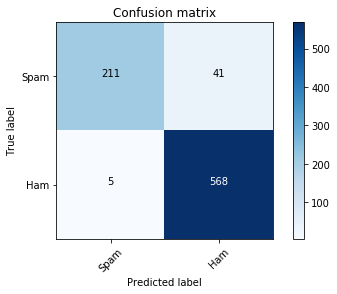

In [11]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

### Supervised - SVM

In [35]:
print "Training SVM Model..."
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
print "Model trained!"

training_error = 1-clf.score(X_train, y_train)
test_error = 1-clf.score(X_test, y_test)
print "Training error : " + str(training_error)
print "Test error : " + str(test_error)


Training SVM Model...
Model trained!
Training error : 0.314626865672
Test error : 0.305454545455


# Prediction

In [36]:
#%run ExtractContent.py TT/ TEST/

## For Train/test split

In [41]:
mails = get_mails('TEST', 'TEST')
X_test = tfidf_vectorizer.transform(mails)

# Train again the classifier on the whole datasets (X, y) including testing datasets
# with the best hyper parameters
best_max_depth = 7
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_max_depth) # classifier = learning algorithm that will learn from the training dataset
model.fit(X, y)

# Now predict new mails from the TEST dataset (non-labeled)
y_pred = model.predict(X_test)

In [42]:
# Store predicted labels
fd = open('spam-mail.tt.label', 'w')
fd.write('Id,Prediction')

for i in range(0, len(y_pred)):
    fd.write('\n%d,%s' % (i+1, y_pred[i]))

fd.close()


## Decision Tree

In [26]:
from sklearn.model_selection import GridSearchCV
d_range = list(range(1, 31)) # list of parameter values to test
#s_range = list(range(2, 10))

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=d_range)#, min_samples_split=s_range)

dtc = tree.DecisionTreeClassifier(criterion='entropy')
grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy', n_jobs=-1) # Do a 10-fold cross validation
grid.fit(X, y) # fit the grid with data



GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

[ 0.84    0.8516  0.8992  0.9284  0.9308  0.934   0.9344  0.9364  0.9388
  0.9404  0.9556  0.9544  0.9544  0.956   0.9548  0.9568  0.9556  0.9584
  0.9568  0.9532  0.9572  0.958   0.9544  0.9584  0.956   0.9568  0.956
  0.9584  0.958   0.9584]


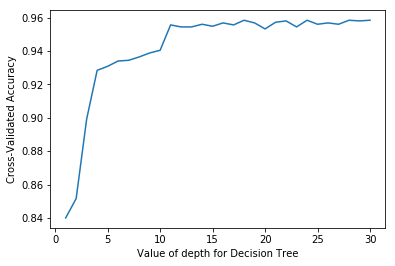

In [28]:
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
#print(grid.best_estimator_)

In [ ]:
#k-NN, Naive Bayes, SVM, Perceptron

## k-NN classifier

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 31)) # list of parameter values to test
param_grid = dict(n_neighbors=k_range)

knn = KNeighborsClassifier(weights='uniform')
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs=-1) # Do a 10-fold cross validation
grid.fit(X, y) # fit the grid with data


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [17]:
print(grid.best_score_)
print(grid.best_params_)

0.9644
{'n_neighbors': 1}


In [16]:
print(grid.cv_results_)

{'rank_test_score': array([ 1,  3,  2,  5,  4,  6,  7, 28,  9, 18, 11, 11,  8, 11, 11, 11, 16,
       16,  9, 23, 19, 20, 20, 23, 20, 26, 26, 29, 23, 30], dtype=int32), 'split6_test_score': array([ 0.968,  0.956,  0.952,  0.94 ,  0.932,  0.924,  0.92 ,  0.916,
        0.924,  0.932,  0.92 ,  0.928,  0.924,  0.928,  0.928,  0.932,
        0.932,  0.932,  0.928,  0.936,  0.932,  0.932,  0.928,  0.928,
        0.928,  0.924,  0.924,  0.924,  0.928,  0.924]), 'param_n_neighbors': masked_array(data = [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False],
       fill_value = ?)
, 'split7_train_score': array([ 1.        ,  0.98444444,  0.97555556,  0.96711111,  0.96444444,
        0.956     ,  0.95288889,  0.948     ,  0.95466667,  0.95377778,
        0.95422222

In [21]:
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

[ 0.9644  0.9524  0.9532  0.9452  0.9456  0.9428  0.9412  0.9364  0.9404
  0.9384  0.94    0.94    0.9408  0.94    0.94    0.94    0.9392  0.9392
  0.9404  0.9372  0.938   0.9376  0.9376  0.9372  0.9376  0.9368  0.9368
  0.9348  0.9372  0.934 ]


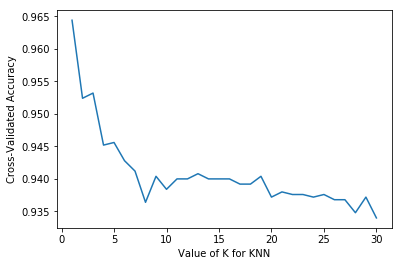

In [24]:
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## SVM - Support Vector Machine

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn import svm
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

svm = svm.SVC()
grid = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', n_jobs=2) # Do a 10-fold cross validation
grid.fit(X, y) # fit the grid with data


In [ ]:
grid_mean_scores = grid.cv_results_['mean_test_score']
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

training_error = gnb.score(X_train, y_train)
test_error = gnb.score(X_test, y_test)

print "Training error : " + str(training_error)
print "Test error : " + str(test_error)


Training error : 1.0
Test error : 0.922424242424


In [25]:
from sklearn.naive_bayes import MultinomialNB

gnb = MultinomialNB()
gnb.fit(X_train, y_train)

training_error = gnb.score(X_train, y_train)
test_error = gnb.score(X_test, y_test)

print "Training error : " + str(training_error)
print "Test error : " + str(test_error)



Training error : 0.911044776119
Test error : 0.883636363636


In [26]:
from sklearn.naive_bayes import BernoulliNB

gnb = BernoulliNB()
gnb.fit(X_train, y_train)

training_error = gnb.score(X_train, y_train)
test_error = gnb.score(X_test, y_test)

print "Training error : " + str(training_error)
print "Test error : " + str(test_error)

Training error : 0.839402985075
Test error : 0.825454545455
